### Implementation


#### Import libraries


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
!pwd

/content/drive/MyDrive/ColabNotebooks/DES


In [ ]:
%rm -rf ScoreTestItemClassification-1/

#### Preping the Data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("soringritco").project("scoretestitemclassification")
dataset = project.version(1).download("yolov5")

In [ ]:
import cv2
import os
import shutil

def crop_images(path, path_out):
    path_images = os.path.join(path, 'images')
    path_labels = os.path.join(path, 'labels')

    print(path_out)
    if os.path.exists(path_out) == True:
      shutil.rmtree(path_out)
    
    if os.path.exists(path_out) == False:
      os.makedirs(path_out)

    for root, dirs, files in os.walk(path_images):
      for file in files:
        image_path = os.path.join(path_images, file)
        filename_without_ext = os.path.splitext(file)[0] 
        label_path = os.path.join(path_labels, filename_without_ext)
        label_path = label_path + '.txt'

        image = cv2.imread(image_path)
        dh, dw, _ = image.shape

        file_labels = open(label_path, 'r')
        boxes = file_labels.readlines()

        counter = 0
        for box in boxes:
          class_id, x_center, y_center, w, h = box.strip().split()
          x_center, y_center, w, h = float(x_center), float(y_center), float(w), float(h)
          x_center = round(x_center * dw)
          y_center = round(y_center * dh)
          w = round(w * dw)
          h = round(h * dh)
          x = round(x_center - w / 2)
          y = round(y_center - h / 2)

          counter += 1
          image_crop = image[y:y + h, x:x + w]

          separator = '_'

          image_filename = '_'.join(filename_without_ext.split('_')[0:2]) 
          
          image_filename = str(class_id)+'_'+image_filename + '_' + str(counter).zfill(4) + '.jpg'
          print(image_filename)
          cv2.imwrite(os.path.join(path_out, image_filename), image_crop)

    

In [ ]:
path = 'ScoreTestItemClassification-1/train'
path_out = 'datasets/ScoreTestItemClassificationCropped/train'
crop_images(path=path, path_out=path_out)

In [ ]:
path = 'ScoreTestItemClassification-1/valid'
path_out = 'datasets/ScoreTestItemClassificationCropped/valid'
crop_images(path=path, path_out=path_out)

# path = 'ScoreTestItemClassification-1/test'
# path_out = 'datasets/ScoreTestItemClassificationCropped/test'
# crop_images(path=path, path_out=path_out)

In [4]:
def prepare_df(dataset_type):
    X = []
    y = []
    path = 'datasets/ScoreTestItemClassificationCropped/' + dataset_type + '/'

    for i in os.listdir(path):
        # Image
        X.append(i)
        # Label
        if i.split('_')[0] == '7':
          y.append('L')
        else: 
          y.append(i.split('_')[0])

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame()
    df['filename'] = X
    df['label'] = y

    return df 

In [5]:
df_train = prepare_df('train')
df_valid = prepare_df('valid')
# df_test = prepare_df('test')

In [6]:
df_valid.head(5)

,filename,label
0,4_20201104_175035_0001.jpg,4
1,0_20201104_175035_0002.jpg,0
2,1_20201104_175035_0003.jpg,1
3,2_20201104_175035_0004.jpg,2
4,0_20201104_175035_0005.jpg,0


In [7]:
df_train.head(5)

,filename,label
0,4_20201104_175012_0001.jpg,4
1,0_20201104_175012_0002.jpg,0
2,0_20201104_175012_0003.jpg,0
3,4_20201104_175012_0004.jpg,4
4,4_20201104_175012_0005.jpg,4


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
)

valid_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory='datasets/ScoreTestItemClassificationCropped/train/',
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
)

valid_generator = train_datagen.flow_from_dataframe(
    df_valid,
    directory='datasets/ScoreTestItemClassificationCropped/valid/',
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=(224, 224),
)

Found 98 validated image filenames belonging to 8 classes.
Found 21 validated image filenames belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(8, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.fit(train_generator, epochs=100, validation_data=valid_generator)

Epoch 1/100
3/3 [==============================] - 6s 1s/step - loss: 3.0629 - accuracy: 0.1979 - val_loss: 2.7811 - val_accuracy: 0.1304
Epoch 2/100
3/3 [==============================] - 2s 603ms/step - loss: 2.2431 - accuracy: 0.1667 - val_loss: 2.2276 - val_accuracy: 0.2609
Epoch 3/100
3/3 [==============================] - 2s 612ms/step - loss: 1.8599 - accuracy: 0.3125 - val_loss: 2.1471 - val_accuracy: 0.2609
Epoch 4/100
3/3 [==============================] - 2s 613ms/step - loss: 1.9372 - accuracy: 0.2292 - val_loss: 2.1688 - val_accuracy: 0.3043
Epoch 5/100
3/3 [==============================] - 2s 587ms/step - loss: 1.6892 - accuracy: 0.2917 - val_loss: 1.9208 - val_accuracy: 0.3478
Epoch 6/100
3/3 [==============================] - 2s 609ms/step - loss: 1.4893 - accuracy: 0.3854 - val_loss: 2.1328 - val_accuracy: 0.3043
Epoch 7/100
3/3 [==============================] - 2s 604ms/step - loss: 1.4384 - accuracy: 0.4271 - val_loss: 1.9983 - val_accuracy: 0.4348
Epoch 8/100
3/3 

In [ ]:
model.save('./resnet50_scoretestitem')

In [8]:
model = tf.keras.models.load_model('resnet50_scoretestitem')

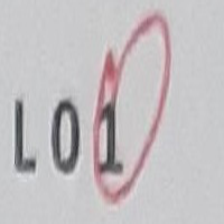

In [11]:
from PIL import Image
img = Image.open('datasets/ScoreTestItemClassificationCropped/valid/1_20201104_175035_0003.jpg')
img = img.resize((224, 224))
img



In [12]:
img = np.array(img)
img = np.expand_dims(img, 0)

class_labels = ['0', '1', '2', '3', '4', '5', '6', 'L']

pred = np.argmax(model.predict(img), axis=-1)
print(class_labels[pred[0]])

1/1 [==============================] - 0s 22ms/step
1


### Creating Gradio Interface

In [ ]:
from PIL import Image
img = Image.open('datasets/ScoreTestItemClassificationCropped/valid/0_20201104_175035_0002.jpg')
img = img.resize((224, 224))
img


def classify_image(img):
  ## img = Image.open('datasets/ScoreTestItemClassificationCropped/valid/0_20201104_175035_0002.jpg')
  img = img.resize((224, 224))
  img = np.array(img)
  img = np.expand_dims(img, 0)

  class_labels = ['0', '1', '2', '3', '4', '5', '6', 'L']
  model = tf.keras.models.load_model('resnet50_scoretestitem')
  
  prediction = model.predict(img).flatten()
  confidences = {class_labels[i]: float(prediction[i]) for i in range(8)}

  return confidences

In [ ]:
! pip install -q gradio

In [ ]:
import gradio as gr

gr.Interface(fn=classify_image, 
             inputs=gr.Image(shape=(224, 224)),
             outputs=gr.Label(num_top_classes=3)
             ).launch(debug=True)